## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


Using TensorFlow backend.


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 4s 0us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 2s 1us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 211s 17ms/step - loss: 0.4640 - accuracy: 0.7749 - val_loss: 0.4038 - val_accuracy: 0.8356
Epoch 2/3
12500/12500 [==============================] - 209s 17ms/step - loss: 0.2500 - accuracy: 0.9054 - val_loss: 0.4386 - val_accuracy: 0.8361
Epoch 3/3
12500/12500 [==============================] - 206s 16ms/step - loss: 0.1720 - accuracy: 0.9374 - val_loss: 0.4526 - val_accuracy: 0.8101
Desempeño (exactitud): accu_v1=0.8100799918174744 , accu_v2=0.8087199926376343
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 207s 17ms/step - loss: 0.3822 - accuracy: 0.8397 - val_loss: 0.3092 - val_accuracy: 0.8776
Epoch 2/3
12500/12500 [==============================] - 207s 17ms/step - loss: 0.1743 - accuracy: 0.9397 - val_loss: 0.3197 - val_acc

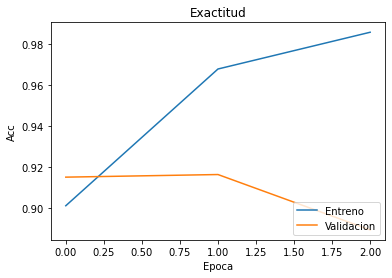

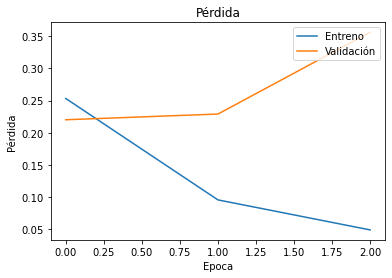

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [12]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11238  1262]
 [ 1734 10766]]
Exactitud:  0.8801599740982056


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [13]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10380  2120]
 [ 2662  9838]]
Exactitud:  0.8087199926376343


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [17]:
# Input con secuencias de enteros con longitud variable
inputs1_1 = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x1_1 = layers.Embedding(max_features, 128)(inputs1_1)

# Añadimos 2 unidades LSTM Unidireccionales
x1_1 = layers.LSTM(64, return_sequences=True)(x1_1)
x1_1 = layers.LSTM(64)(x1_1)

# Añadimos un clasificador binario en la salida
outputs1_1 = layers.Dense(1, activation="sigmoid")(x1_1)

# Gaurdamos la arquitectura del modelo
model1_1 = keras.Model(inputs1_1, outputs1_1)
model1_1.name = "Modelo Ejercicio 1.1"
model1_1.summary()

Model: "Modelo Ejercicio 1.1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Inicializamos la tabla donde guardamos los resultados
x1_1 = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model1_1 = keras.Model(inputs1_1, outputs1_1)
    model1_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history1_1=model1_1.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model1_1.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model1_1.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model1_1.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('LSTM_Unidir_1_1='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 106s 8ms/step - loss: 0.4492 - accuracy: 0.7838 - val_loss: 0.3889 - val_accuracy: 0.8254
Epoch 2/3
12500/12500 [==============================] - 102s 8ms/step - loss: 0.2522 - accuracy: 0.9013 - val_loss: 0.4563 - val_accuracy: 0.8057
Epoch 3/3
12500/12500 [==============================] - 105s 8ms/step - loss: 0.1826 - accuracy: 0.9331 - val_loss: 0.4162 - val_accuracy: 0.8229
Desempeño (exactitud): accu_v1=0.8228800296783447 , accu_v2=0.8200399875640869
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 104s 8ms/step - loss: 0.4118 - accuracy: 0.8240 - val_loss: 0.3176 - val_accuracy: 0.8706
Epoch 2/3
12500/12500 [==============================] - 102s 8ms/step - loss: 0.1844 - accuracy: 0.9326 - val_loss: 0.2878 - val_accuracy: 0.8910
Epoch 3/3
12500/12500 [==============================] - 101s 8ms/step - loss: 0.0967 

In [27]:
# Input con secuencias de enteros con longitud variable
inputs1_2 = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x1_2 = layers.Embedding(max_features, 128)(inputs1_2)

# Añadimos 2 unidades de GRU Unidireccionales
x1_2 = layers.GRU(64, return_sequences=True)(x1_2)
x1_2 = layers.GRU(64)(x1_2)

# Añadimos un clasificador binario en la salida
outputs1_2 = layers.Dense(1, activation="sigmoid")(x1_2)

# Gaurdamos la arquitectura del modelo
model1_2 = keras.Model(inputs1_2, outputs1_2)
model1_2.name = "Modelo Ejercicio 1.1 GRU"
model1_2.summary()

Model: "Modelo Ejercicio 1.1 GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
gru_4 (GRU)                  (None, None, 64)          37056     
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,621,889
Trainable params: 2,621,889
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Inicializamos la tabla donde guardamos los resultados
x1_2 = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model1_2 = keras.Model(inputs1_2, outputs1_2)
    model1_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history1_2=model1_2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model1_2.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model1_2.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model1_2.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('GRU_Unidir_1_2='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 135s 11ms/step - loss: 0.5016 - accuracy: 0.7488 - val_loss: 0.3711 - val_accuracy: 0.8452
Epoch 2/3
12500/12500 [==============================] - 135s 11ms/step - loss: 0.2707 - accuracy: 0.8903 - val_loss: 0.3965 - val_accuracy: 0.8421
Epoch 3/3
12500/12500 [==============================] - 137s 11ms/step - loss: 0.1491 - accuracy: 0.9460 - val_loss: 0.4916 - val_accuracy: 0.8410
Desempeño (exactitud): accu_v1=0.8409600257873535 , accu_v2=0.8334400057792664
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 138s 11ms/step - loss: 0.3023 - accuracy: 0.8766 - val_loss: 0.2573 - val_accuracy: 0.9005
Epoch 2/3
12500/12500 [==============================] - 133s 11ms/step - loss: 0.1310 - accuracy: 0.9539 - val_loss: 0.3541 - val_accuracy: 0.8822
Epoch 3/3
12500/12500 [==============================] - 132s 11ms/step - loss: 0

Como podemos observar, la red neuronal con 2 capas GRU unidireccional con seed=2 es el mejor modelo segun exactitud en V y el segundo mejor en exactitud en Prueba. En este segundo item, es superado muy ligeramente por otra red neuronal unidireccional con GRU de seed=1.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

In [29]:
# Input con secuencias de enteros con longitud variable
inputs1_3 = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x1_3 = layers.Embedding(max_features, 128)(inputs1_3)
# Añadimos 2 unidades de GRU Bidireccionales
x1_3 = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x1_3)
x1_3 = layers.Bidirectional(layers.GRU(64))(x1_3)
# Añadimos un clasificador binario en la salida
outputs1_3 = layers.Dense(1, activation="sigmoid")(x1_3)
# Gaurdamos la arquitectura del modelo
model1_3 = keras.Model(inputs1_3, outputs1_3)
model1_3.name = "Modelo Ejercicio 1.2 GRU Bidireccional"
model1_3.summary()

Model: "Modelo Ejercicio 1.2 GRU Bidireccional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         74112     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               74112     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,708,353
Trainable params: 2,708,353
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Inicializamos la tabla donde guardamos los resultados
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model1_3 = keras.Model(inputs1_3, outputs1_3)
    model1_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history1_3=model1_3.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model1_3.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model1_3.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model1_3.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('GRU_Bidir_1_3='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 265s 21ms/step - loss: 0.4986 - accuracy: 0.7442 - val_loss: 0.3572 - val_accuracy: 0.8484
Epoch 2/3
12500/12500 [==============================] - 265s 21ms/step - loss: 0.2478 - accuracy: 0.9020 - val_loss: 0.3920 - val_accuracy: 0.8493
Epoch 3/3
12500/12500 [==============================] - 259s 21ms/step - loss: 0.1418 - accuracy: 0.9501 - val_loss: 0.6871 - val_accuracy: 0.7914
Desempeño (exactitud): accu_v1=0.7913600206375122 , accu_v2=0.781440019607544
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 260s 21ms/step - loss: 0.2720 - accuracy: 0.8909 - val_loss: 0.2421 - val_accuracy: 0.9063
Epoch 2/3
12500/12500 [==============================] - 258s 21ms/step - loss: 0.0744 - accuracy: 0.9768 - val_loss: 0.3421 - val_accuracy: 0.8884
Epoch 3/3
12500/12500 [==============================] - 259s 21ms/step - loss: 0.

Luego de varios intentos, observamos que el modelo con 2 capas gru bidireccionales mejora el desempeño vs el modelo inicial comparando la exactitud en V y en P usando seed = 2. Ahora probamos de forma individual este modelo:

In [39]:
# Modelo Ganador
model1_3 = load_model('GRU_Bidir_1_3=3.h5')
model1_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [43]:
Y_predt = model1_3.predict(x_train)
Y_predst = (Y_predt > 0.5)
print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model1_3.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11997   503]
 [  359 12141]]
Exactitud:  0.9655200242996216


In [42]:
Y_predv = model1_3.predict(x_val)
Y_predsv = (Y_predv > 0.5)
print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model1_3.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10674  1826]
 [ 1710 10790]]
Exactitud:  0.8585600256919861


Observamos una exactitud en los datos de prueba de la muestra de 0.9655 y de 0.8586 en los datos de prueba de fuera de la muestra, con lo cual, este es nuestro mejor modelo.

Para seguir mejorando los resultados, se propone mezclar distintos tipos de estructuras de redes con mas de 3 validaciones cruzadas que tengan capas recurrentes bidireccionales, ya que estas, como se vio en el ejercicio, tienen mejor desempeño vs las redes recurrentes unidireccionales para temas referentes a procesamiento de lenguaje natural. Para esta muestra de datos, una estructura de red neuronal con redes recurrentes bidireccionales GRU obtuvo mejor desempeño que una red neuronal con redes recurrentes bidireccionales LSTM. 